In [1]:
import os
import datetime
from importlib import reload

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import *

%matplotlib inline
pd.options.display.max_columns = 150

# Player-level Analysis POC
Previous attempts at a high performing model have been unsucessful. I will now try to create a model per 'high performing' batter, hoping to take advantage of within-person effects. I will have to be especially careful about overfitting due to the small sample size, and data is a few years old at this point, so it might not translate well enough for current predictions.

In [37]:
df = load_analysis_set(1)
df_hitters = df.groupby('name').got_hit.agg(['mean', 'count'])
df_hitters = df_hitters[df_hitters['count'] > 250]
df_hitters.sort_values('mean', ascending = False)

,mean,count
name,,
Jose Altuve,0.776119,469
Mookie Betts,0.766764,343
Jose Abreu,0.764977,434
Michael Brantley,0.763514,296
Daniel Murphy,0.749392,411
Dustin Pedroia,0.748663,374
Dee Gordon,0.747945,365
Jose Reyes,0.744479,317
Kris Bryant,0.743151,292


## Daniel Hits Murphy

In [2]:
# try approach with Daniel Hits Murphy
df = load_analysis_set(1)
df = df[df.name == 'Daniel Murphy']

In [17]:
df.head(1)

,date,home,matchup,opp_pitcher,opp_pitcher_lefty,opp_team,own_pitcher,own_pitcher_lefty,team,date_m1,team_fg,opp_team_fg,got_hit,name,model_set,fs_id,p7__Team,p7__PA,p7__BB%,p7__K%,p7__AVG,p7__ISO,p7__BABIP,p7__wRAA
0,2016-07-17,True,Pittsburgh Pirates @ Washington Nationals,Chad Kuhl,False,Pittsburgh Pirates,Max Scherzer,False,Washington Nationals,2016-07-16,WSN,PIT,True,Daniel Murphy,train,135,WSN,9.0,11.1,11.1,0.5,0.875,0.4,3.3


In [7]:
# simply picking murph, gives a 75% chance
df.got_hit.mean()

0.74939172749391725

In [12]:
temp_df = load_data('hitting/week_master','p7')
right_variables = ['p7__Date','p7__Team','p7__Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
df = pd.merge(df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','name'],
                right_on=right_variables)

In [13]:
df.shape

(411, 34)

In [16]:
df.drop(['p7__Date', 'p7__Season', 'p7__Name', 
         'p7__BB/K', 'p7__OBP','p7__SLG', 
         'p7__OPS', 'p7__wRC', 'p7__wOBA', 'p7__wRC+', 'p7__Team'], inplace = True, axis = 1)

In [20]:
df.drop('p7__Team', inplace = True, axis = 1)

In [18]:
# baseline
m = df.model_set == 'dev'
t = random_predictions(df)
print(metrics.classification_report(y_pred=t, y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.225     0.231     0.228        39
       True      0.730     0.723     0.726       112

avg / total      0.599     0.596     0.598       151



In [23]:
df.dropna(inplace = True)

In [42]:
#features = [x for x in df.columns if x not in not_features]
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_features=None)
m = df.model_set == 'train'
rfc.fit(df.loc[m,features], df[m]['got_hit'])
m = df.model_set == 'dev'
dev_probs = rfc.predict_proba(df.loc[m,features])[:,1]

In [41]:
features = ['p7__BABIP', 'p7__K%', 'p7__ISO']
features = ['p7__BABIP', 'p7__ISO']

In [45]:
thresh = np.percentile(dev_probs, 95)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.257     0.972     0.407        36
       True      0.875     0.065     0.121       108

avg / total      0.721     0.292     0.192       144



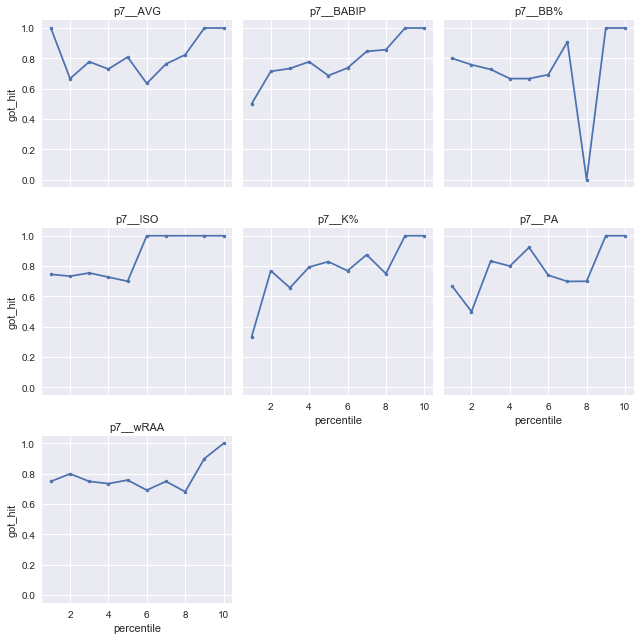

In [29]:
cols = [x for x in df.columns if x.startswith('p7')]
rate_histogram(df, cols)

## Jose Altuve

In [54]:
df = load_analysis_set(1)
df = df[df.name == 'Jose Altuve']

temp_df = load_data('hitting/week_master','p7')
right_variables = ['p7__Date','p7__Team','p7__Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
df = pd.merge(df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','name'],
                right_on=right_variables)

df.drop(['p7__Date', 'p7__Season', 'p7__Name', 
         'p7__BB/K', 'p7__OBP','p7__SLG', 
         'p7__OPS', 'p7__wRC', 'p7__wOBA', 'p7__wRC+', 'p7__Team'], inplace = True, axis = 1)

df.dropna(inplace = True)

# baseline
m = df.model_set == 'dev'
t = random_predictions(df)
print(metrics.classification_report(y_pred=t, y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.229     0.282     0.253        39
       True      0.816     0.770     0.792       161

avg / total      0.701     0.675     0.687       200



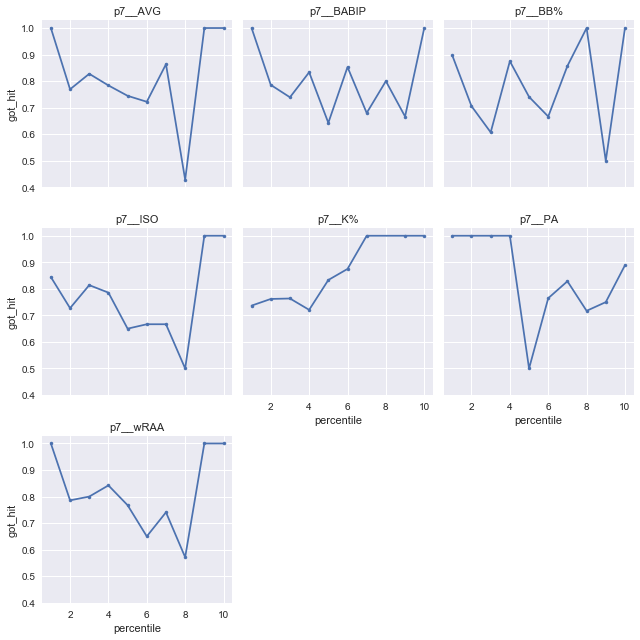

In [55]:
cols = [x for x in df.columns if x.startswith('p7')]
rate_histogram(df, cols)

## Kris Bryant

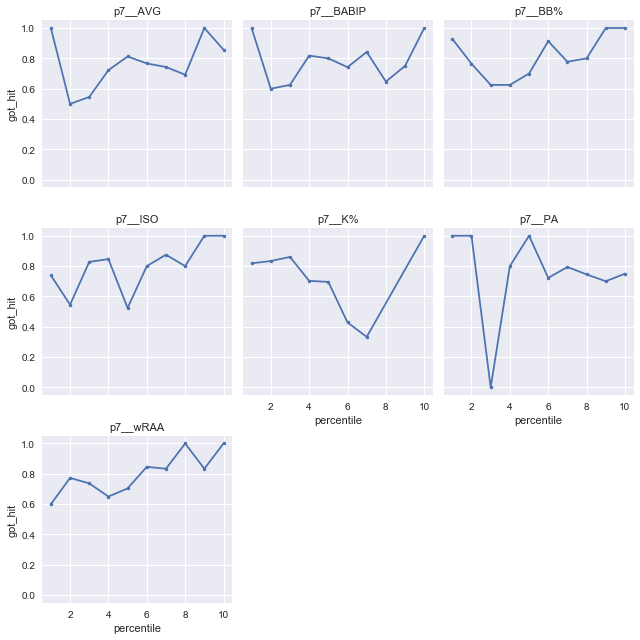

In [56]:
df = load_analysis_set(1)
df = df[df.name == 'Kris Bryant']

temp_df = load_data('hitting/week_master','p7')
right_variables = ['p7__Date','p7__Team','p7__Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
df = pd.merge(df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','name'],
                right_on=right_variables)

df.drop(['p7__Date', 'p7__Season', 'p7__Name', 
         'p7__BB/K', 'p7__OBP','p7__SLG', 
         'p7__OPS', 'p7__wRC', 'p7__wOBA', 'p7__wRC+', 'p7__Team'], inplace = True, axis = 1)

df.dropna(inplace = True)
cols = [x for x in df.columns if x.startswith('p7')]
rate_histogram(df, cols)

So, it appears that different statistics are important to different players. For example, there is a clear positive trend for Daniel Murphy in BABIP, but BABIP is less important for Jose Altuve. Makes sense; whi;e they are both great hitters, they are different types of hitters with different tendencies. Let's dig into this approach in another notebook.

## Get Player IDs
Let's join the fangraphs player ids for the top performing hitters to make our analysis a little safer. Player Ids were, unfortunately, not a column in the original data scrape.

In [38]:
# start with 50 hitters with highest BTS performance
print((df_hitters['mean'] > .69).sum())
df_hitters = df_hitters[df_hitters['mean'] > .69]
orig_shape = len(df_hitters)
df_hitters.rename(columns={'mean': 'hit_pct_meta', 'count':'sample_size'}, inplace = True)
assert(len(df_hitters) == orig_shape) #check to see if name is not unique to player
df_hitters.reset_index(inplace = True)

# pull in player id
df_pids = pd.read_csv('p_ids2.csv')
df_hitters = pd.merge(df_hitters, df_pids, how = 'left', on = 'name')
df_hitters.drop(['Team', 'G'], inplace = True, axis = 1)

50


In [31]:
df_hitters.head()

,name,hit_pct_meta,sample_size,player_id
0,Adam Eaton,0.715640,422,11205.0
1,Adam Jones,0.696347,438,6368.0
2,Adrian Beltre,0.714286,441,639.0
3,Alcides Escobar,0.713062,467,6310.0
4,Andrew McCutchen,0.709821,448,9847.0


In [39]:
df_hitters.to_csv('select_players.csv', index = False)